# Network Analysis Project
## Crime Network Analysis
Professor: Michele Coscia

This notebook contains all of the code developed for the Network Analysis Course at ITU. We will be using...**finish**

**Add Description**

Group 10:  
Carl August Wismer ([cwis@itu.dk](mailto:cwis@itu.dk))  <br>
Crisanna Cornish ([ccor@itu.dk](mailto:ccor@itu.dk))  <br>
Danielle Dequin ([ddeq@itu.dk](mailto:ddeq@itu.dk))  <br>
Maria Do Carmo Madeira Santos Silva Passos de Sousa ([mdom@itu.dk](mailto:mdom@itu.dk))  <br>
Moneeca Abru Iftikhar Latif ([abml@itu.dk](mailto:abml@itu.dk))  <br>
Sabrina Fonseca Pereira ([sabf@itu.dk](mailto:sabf@itu.dk))  <br>

Created: 27-09-2021  
Last Modified: 02-10-2021

# Data Source

The data are a network of associations among suspects, victims, and/or witnesses involved in crimes in St. Louis in the 1990s. Data are derived from police records, via snowball sampling from five initial homicides. Left nodes are people, right nodes are crime events, and edges connect people to particular crimes events they were associated with. Metadata includes names, genders, and roles (suspects, victims, and/or witnesses).

This is an undirected, unweighted, bipartite network with 1380 nodes and 1476 edges.

Data can be downloaded [here](http://konect.cc/networks/moreno_crime/) or [here](https://networks.skewed.de/net/crime).

# Imports

In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from scipy.stats import linregress
from scipy.optimize import curve_fit
import powerlaw as pl

# PATHS

In [2]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

# Constants

# Functions

# Load Data

In [3]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i] # adds 'p' to the People nodes to differentiate them

In [4]:
B = nx.read_edgelist(data) # read edgelist in
print(len(B.nodes()), len(B.edges())) # sanity check (1380, 1476)

1380 1476


In [5]:
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

print(f"There are {len(a)} unique people and {len(b)} unique crime events.")

There are 829 unique people and 551 unique crime events.


## Create Graph

In [6]:
G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, name=name[j], sex=sex[j]) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role=role[i]) # why role is in a list?
    i+=1

In [7]:
# sanity check
print(
    'Num. of nodes: {} \nNum. of edges: {} \nIs bipartite? {} \nIs connected? {}'.format(
        G.number_of_nodes(), 
        G.number_of_edges(), 
        nx.is_bipartite(G),
        nx.is_connected(G)
        )
    )

Num. of nodes: 1380 
Num. of edges: 1476 
Is bipartite? True 
Is connected? False


From the [official Networkx docs](https://networkx.org/documentation/stable/reference/algorithms/bipartite.html):

Many algorithms of the bipartite module of NetworkX require, as an argument, a container with all the nodes that belong to one set, in addition to the bipartite graph B. The functions in the bipartite package do not check that the node set is actually correct nor that the input graph is actually bipartite. If B is connected, you can find the two node sets using a two-coloring algorithm:

```py
>>> nx.is_connected(B)
True
>>> bottom_nodes, top_nodes = bipartite.sets(B)
```
However, if the input graph is not connected, there are more than one possible colorations. This is the reason why we require the user to pass a container with all nodes of one bipartite node set as an argument to most bipartite functions. In the face of ambiguity, we refuse the temptation to guess and raise an AmbiguousSolution Exception if the input graph for bipartite.sets is disconnected.

Using the bipartite node attribute, you can easily get the two node sets:

In [8]:
top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # people
bottom_nodes = set(G) - top_nodes # crimes

## Adding metadata to nodes

In [9]:
print(nx.get_node_attributes(G, 'name')['p1']) # check name of person 'p1' = 'AbelDennis'
print(nx.get_node_attributes(G, 'sex')['p1']) # check sex of person 'p1' = '1'

AbelDennis
1


In [10]:
nx.get_edge_attributes(G, 'role')['p1', '1']
# check role of edge between person p1 and crime 1 = 'Suspect'

'Suspect'

# Exploratory Data Analysis

## Graph stats

### *Density:* probability that a random node pair is connected or, the number of edges in a network over the total possible number of edges that can exist given the number of nodes. 
    In our case, we have a probablity of 0.003 which means that our network is quite sparse.

In [65]:
print(
    'Density: {} \nAvarage clustering: {}'.format(
        round(bipartite.density(G, bottom_nodes),3),
        round(bipartite.average_clustering(G),3)
        )
    )

Density: 0.003 
Avarage clustering: 0.427


### *Clustering coefficient:* number of common neighbors around a node connected to each other. How often does a triad (set of three connected nodes) closes down into a triangle (three nodes that are all connected to each other)? 
#### Note_1: in the formula, we multiply by 3 because a single triangle closes three triads.
#### Note_2: local, global and average clustering coefficients are different.

    In our case, almost half of the triads (0.43) in the network close to form a triangle. 


In [64]:
cluster = bipartite.clustering(B)
round(sum(cluster.values())/len(cluster.values()),3)

0.427

## **Looking for both density and clustering coefficient values, our network follows the real world network caracterists having few connections per node, but these connections tend to be clustered in the same neighborhood. Nodes tend to close triangles.**

## Nodes stats

### *Closeness centrality:* inverse average path length. The closer a node are on average to every other nodes, the more central it is.
### *Betweenness centrality:* total number of paths that can pass through a node – excluding the ones for which it is the origin or the destination; how many paths would become longer if node v would disappear from the network?

In [54]:
# dicts with stats for each node
clustering = bipartite.clustering(G)
betweenness_centrality = bipartite.betweenness_centrality(G, top_nodes)
closeness_centrality = bipartite.closeness_centrality(G, top_nodes)

#f'Closeness centrality value: {closeness_centrality}, betweenness centrality value: {betweenness_centrality}'

In [14]:
global_clustering = bipartite.robins_alexander_clustering(G)
avg_clustering = bipartite.average_clustering(G, top_nodes)

### *Avg degree:* average number of edges each node uses to connect to its neighbors. Depending on the number of nodes and the avg degree, we can have an idea of how connected or sparse our network is.

In [60]:
# Node Degree
node_degree = bipartite.degrees(G, top_nodes)
print(node_degree[1]) # Maria: I don't understand the print structure

[('p474', 9), ('p437', 2), ('p129', 5), ('p228', 1), ('p146', 8), ('p287', 1), ('p700', 1), ('p55', 1), ('p758', 2), ('p825', 1), ('p552', 1), ('p638', 1), ('p427', 1), ('p410', 4), ('p401', 1), ('p247', 2), ('p239', 1), ('p680', 4), ('p525', 1), ('p619', 1), ('p722', 1), ('p539', 1), ('p384', 6), ('p507', 1), ('p180', 1), ('p156', 1), ('p527', 1), ('p194', 1), ('p713', 1), ('p82', 3), ('p725', 1), ('p49', 1), ('p277', 7), ('p673', 1), ('p265', 1), ('p242', 5), ('p755', 1), ('p558', 1), ('p350', 1), ('p502', 5), ('p774', 2), ('p538', 1), ('p602', 1), ('p788', 5), ('p490', 2), ('p288', 1), ('p586', 1), ('p797', 7), ('p432', 1), ('p279', 1), ('p723', 3), ('p298', 1), ('p25', 1), ('p61', 1), ('p135', 1), ('p375', 1), ('p440', 1), ('p210', 1), ('p75', 1), ('p100', 1), ('p559', 1), ('p724', 1), ('p128', 6), ('p19', 1), ('p65', 1), ('p470', 2), ('p319', 1), ('p548', 1), ('p217', 1), ('p529', 1), ('p20', 1), ('p59', 1), ('p703', 1), ('p84', 1), ('p618', 1), ('p540', 1), ('p482', 1), ('p243', 

In [16]:
# Average Left Degree

In [17]:
# Average Right Degree

In [18]:
# People node with the most neighbors (Max left degree)
node_neighbors = {n: len(set(G.neighbors(n))) for n in top_nodes}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

p815 25


In [19]:
# Crime node with the most neighbors (Max right degree)
node_neighbors = {n: len(set(G.neighbors(n))) for n in bottom_nodes}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

110 18


## Graph components

In [20]:
# components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
# selecting the biggest component
G0 = G.subgraph(Gcc[0])

In [68]:
# Number of nodes for each component and number of components
comp_list = []
for comp in Gcc:
    comp_len = len(comp)
    comp_list.append(comp_len)

BC_perc = round(comp_list[0]/sum(comp_list) * 100,3)

print(f'Number of nodes for each components: {comp_list} and number of components: {len(comp_list)}.')
print(f'The number of number of nodes in the biggest component represents {BC_perc} % of all nodes.')

Number of nodes for each components: [1263, 30, 18, 13, 9, 7, 6, 5, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2] and number of components: 20.
The number of number of nodes in the biggest component represents 91.522 % of all nodes.


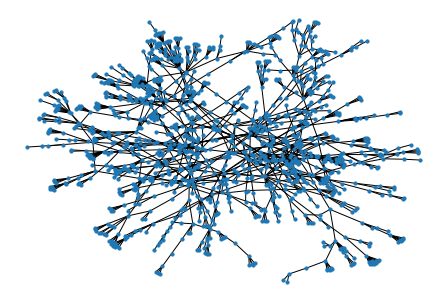

In [22]:
# plot only biggest component
pos = nx.spring_layout(G0)
posB = nx.bipartite_layout(G0, top_nodes)
biggest_comp_graph = nx.draw(G0,pos,node_size=10)

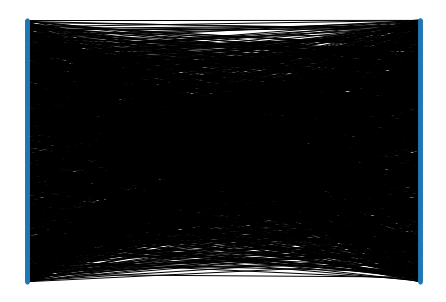

In [23]:
# Biggest component bipartite plot
biggest_comp_graph = nx.draw(G0,posB,node_size=10)

## Plots

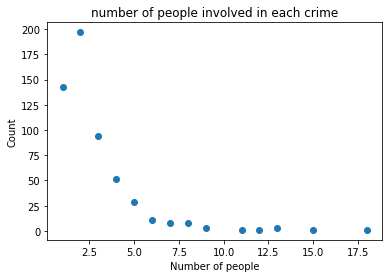

In [24]:
e_p = []
e_c = []
for k in G.nodes():
    if G.nodes[k]["bipartite"] == 0:
        e_p.append(len(G.edges(k)))
    else:
        e_c.append(len(G.edges(k)))

e_cc = Counter(e_c)
plt.scatter(e_cc.keys(), e_cc.values())
plt.title('number of people involved in each crime')
plt.xlabel('Number of people')
plt.ylabel('Count');

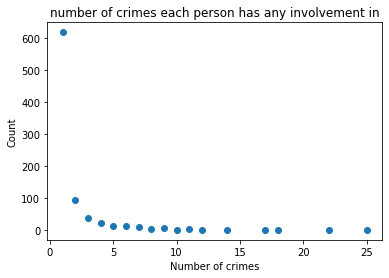

In [25]:
e_pc = Counter(e_p)
plt.scatter(e_pc.keys(), e_pc.values())
plt.title('number of crimes each person has any involvement in')
plt.xlabel('Number of crimes')
plt.ylabel('Count');

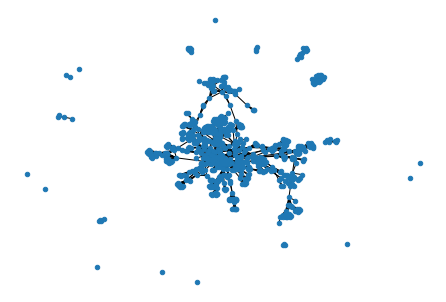

In [26]:
P = bipartite.weighted_projected_graph(G, top_nodes)
nx.draw(P, node_size=20)

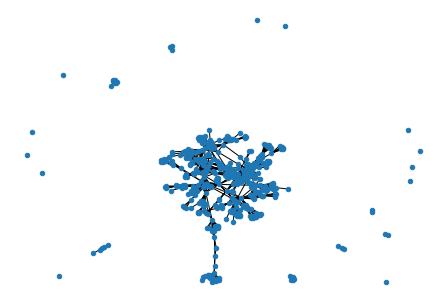

In [27]:
C = bipartite.weighted_projected_graph(G, bottom_nodes)
nx.draw(C, node_size=20)

#### Non-square adjacency matrix, and stocastic matrix

In [28]:
# Non-square adjacency matrix
adjmat = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, top_nodes)
print(adjmat.shape)

(829, 551)


In [29]:
# Project along smaller axis
if adjmat.shape[0] == 551:
    adjmat_proj = adjmat.dot(adjmat.T)
else:
    adjmat_proj = adjmat.T.dot(adjmat)

In [30]:
# Make stocastic
adjmat_proj_stoc = adjmat_proj / adjmat_proj.sum(axis = 1)
print(adjmat_proj_stoc.shape)

(551, 551)


#### Degree distribution in the network

In [31]:
dd = Counter(dict(G.degree).values())
dd = pd.DataFrame(list(dd.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")

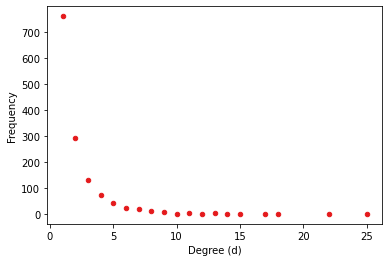

In [32]:
dd.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#e41a1c")
#plt.savefig("../Report/degree_distribution.png")
plt.show()

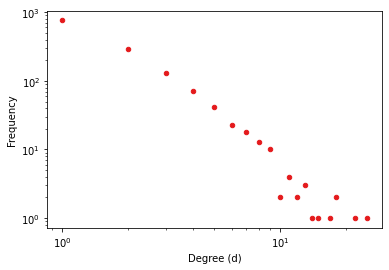

In [33]:
# Loglog scale of the degree distribution
dd.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#e41a1c", loglog = True)
#plt.savefig("../Report/degree_distribution_loglog.png")
plt.show()

#### Cumulative Distribution Function

In [34]:
# Degree distribution
ccdf = dd.sort_values(by = "Degree (d)", ascending = False)
ccdf["cumsum"] = ccdf["Frequency"].cumsum()
ccdf["ccdf: P(X>=d)"] = ccdf["cumsum"] / ccdf["Frequency"].sum()
ccdf = ccdf[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

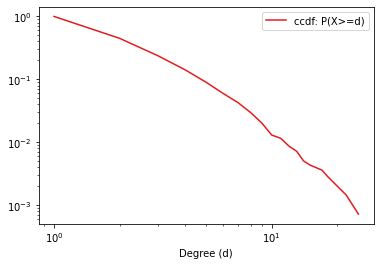

In [35]:
ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True)
#plt.savefig("../Report/degree_distribution_ccdf.png")
plt.show()

#### Fit CCDF to PowerLaw

In [36]:
logcdf = np.log10(ccdf[["Degree (d)", "ccdf: P(X>=d)"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf["Degree (d)"], logcdf["ccdf: P(X>=d)"])
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))

CCDF Fit: 2.4953 x ^ -2.2984 (R2 = 0.9663, p = 0.0000)


In [37]:
results = pl.Fit(ccdf["ccdf: P(X>=d)"])
k_min = ccdf[ccdf["ccdf: P(X>=d)"] == results.power_law.xmin]["Degree (d)"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Powerlaw CCDF Fit: 11.5112 x ^ -1.4393 (k_min = 18)


Calculating best minimal value for power law fit
C:\Users\carmo\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


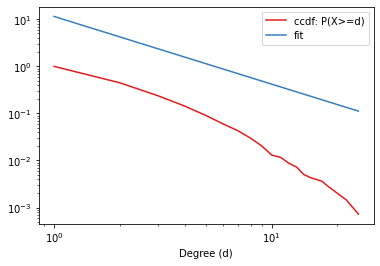

In [38]:
# Plot the best fit.
ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["Degree (d)"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "Degree (d)", y = "fit", color = "#377eb8", loglog = True, ax = ax)
#plt.savefig("../Report/ccdf_fit.png")

#### More Powerlaw Stuff

In [39]:
def f(x, a, l):
    return (x ** a) * np.exp(-l * x) 

def log_f(x, a, l):
    return np.log10(f(x, a, l))

In [40]:
popt, pcov = curve_fit(log_f, ccdf["Degree (d)"], np.log10(ccdf["ccdf: P(X>=d)"]), p0 = (1, 1))
ccdf["fit"] = ccdf.apply(lambda x: f(x["Degree (d)"], popt[0], popt[1]), axis = 1)

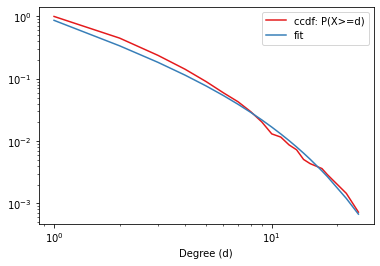

In [41]:
ax = plt.gca()
ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "Degree (d)", y = "fit", color = "#377eb8", loglog = True, ax = ax)
#plt.savefig("../Report/ccdf_fit.png")
plt.show()

# Projections of suspect graph
 Projections of suspect graph  
 From the BCC extracted only the suspect edges and created a new graph that is not connected but still bipartite. From there projected onto people nodes.
- [ ] Figure out how to keep crime name as edge attribute

## Extract suspect edges
Created a new graph with only suspects to do further analysis (try projections).

In [42]:
# selected just the suspect edges
suspect_edges = [(p,c) for p,c,e in G0.edges(data=True) if e['role'] == 'Suspect']
#print(suspect_edges)

## Suspect subgraph

In [43]:
# getting all nodes that have suspect edges
sus_nodes = pd.DataFrame(suspect_edges, columns=['node', 'crime']).iloc[:,0].unique()
sus_nodes = set(sus_nodes)

In [44]:
GS = G0.edge_subgraph(suspect_edges)

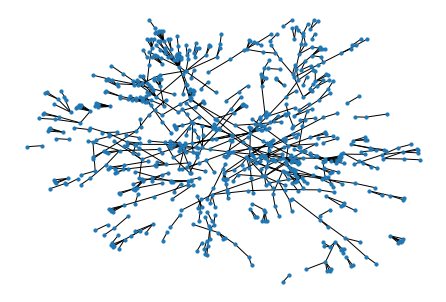

In [45]:
nx.draw(GS,pos,node_size=10)

## Projection on to suspect nodes (people)

In [46]:
nx.is_bipartite(GS)

True

In [47]:
# get the people and crime nodes
people_nodes_GS = {n for n, d in GS.nodes(data=True) if d["bipartite"] == 0}
crime_nodes_GS = set(GS) - people_nodes_GS

In [48]:
# projection of suspect graph
weighted_suspect_graph = nx.bipartite.weighted_projected_graph(GS, people_nodes_GS, ratio=False)
list(weighted_suspect_graph.edges(data=True))[0:5]

[('p474', 'p148', {'weight': 1}),
 ('p474', 'p553', {'weight': 1}),
 ('p437', 'p704', {'weight': 1}),
 ('p437', 'p403', {'weight': 1}),
 ('p437', 'p476', {'weight': 1})]

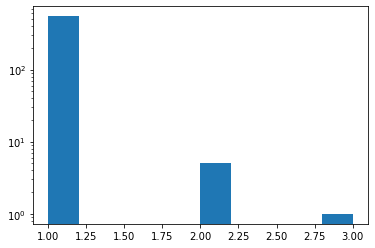

In [49]:
# give the number of shared neighbors
weights = list(nx.get_edge_attributes(weighted_suspect_graph, 'weight').values())

# plot weights
plt.hist(weights, bins = 10, log=True)
plt.show()